# **Modelo de reconocimiento de voz**

## **Autores**

 * Andrik Solano Jiménez
 * Luz Clara Salazar Mora
 * Julio César Castro Ortiz

## Librerías

In [1]:
import matplotlib.pyplot as plt  # Para la visualización de datos, como trazar curvas de aprendizaje, histogramas, etc.
import numpy as np  # Para el manejo de matrices y operaciones numéricas eficientes.
import pandas as pd  # Para el manejo de datos en forma de DataFrame, útil para la manipulación y análisis de datos tabulares.
import time  # Para medir el tiempo de ejecución de ciertas partes del código.
import tensorflow as tf  # El marco principal para la construcción y entrenamiento de modelos de aprendizaje automático.
from IPython import display  # Herramientas para la visualización interactiva dentro de un entorno IPython, útil para mostrar gráficos en jupyter notebooks.
from jiwer import wer  # Para calcular la tasa de error de palabras (Word Error Rate) durante el reconocimiento de voz.
from keras.callbacks import Callback, ModelCheckpoint  # Callbacks útiles durante el entrenamiento del modelo, como ModelCheckpoint para guardar el mejor modelo.
from tensorflow import keras  # Una interfaz de alto nivel para construir y entrenar modelos en TensorFlow.
from tensorflow.keras import layers, models, optimizers  # Componentes para construir modelos de red neuronal, capas, optimizadores, etc.
from tensorflow.keras.backend import ctc_batch_cost as CTCLoss  # Función de pérdida para la tarea de reconocimiento de voz utilizando la pérdida de conexión temporal continua.

## Carga de los datos

Procedemos a cargar los datos desde nuestro dataset propio con las 100 frases

In [29]:
dataset = pd.read_csv('AudioDataset.csv')
print(dataset.head())

                 name                               transcription
0   Andrik/frase1.wav  I enjoy eating avocado toast every morning
1  Andrik/frase2.wav      Titanic is a classic film loved by many
2  Andrik/frase3.wav      A good sense of humor lightens the mood
3  Andrik/frase4.wav      Understanding emotion is key to empathy
4  Andrik/frase5.wav           The human brain is a complex organ


### Tamaño del dataset
Verificamos el tamaño del dataset

In [30]:
# Comprobar el tamaño del dataset
len(dataset)

100

### Dividir conjuntos de entrenamiento y validación

In [31]:

print(f"Size of dataset: {len(dataset)}")

# Dividir el dataset en train y validation
cantidad = 100

train_indices = []
val_indices = []

# Agregar una fila de cada palabra clave al conjunto de validación
for i in range(10):
    val_indices.append(i)

# Agregar las restantes filas al conjunto de entrenamiento
for i in range(10, 100):
    train_indices.append(i)

# Convertir listas a arrays de numpy
train_indices = np.array(train_indices)
val_indices = np.array(val_indices)

# Crear DataFrames de train y validation
df_train = dataset.iloc[train_indices]
df_val = dataset.iloc[val_indices]

# Comprobar los tamaños de los conjuntos
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

# Imprimimos las palabras clave en el conjunto de validacion
palabras_en_val = set(df_val['transcription'])
print(f"Palabras clave en el conjunto de validación: {palabras_en_val}")


Size of dataset: 100
Size of the training set: 90
Size of the validation set: 10
Palabras clave en el conjunto de validación: {'I enjoy eating avocado toast every morning', 'Wine tasting is an enjoyable experience', 'Understanding emotion is key to empathy', 'The human brain is a complex organ', 'The bank offers various types of loan', 'Recruitment processes can be very time consuming', 'Salary negotiation can be challenging but rewarding', 'Flight delays can be very frustrating', 'A good sense of humor lightens the mood', 'Titanic is a classic film loved by many'}


### Verificamos el formato de los audios para asegurarnos de que sean mono

In [32]:
import os
def check_audio_shapes(df):
    for wav_file in df["name"]:
        if not os.path.exists(wav_file):
            print(f"File {wav_file} does not exist.")
            continue
        file = tf.io.read_file(wav_file)
        audio, _ = tf.audio.decode_wav(file, desired_channels=1)
        shape = tf.shape(audio)
        print(f"{wav_file} shape: {shape}")

# Verificar las formas de los archivos en el DataFrame
check_audio_shapes(df_train)
check_audio_shapes(df_val)

Andrik/frase11.wav shape: [218112      1]
Andrik/frase12.wav shape: [212992      1]
Andrik/frase13.wav shape: [189696      1]
Andrik/frase14.wav shape: [181248      1]
Andrik/frase15.wav shape: [165376      1]
Andrik/frase16.wav shape: [219392      1]
Andrik/frase17.wav shape: [226560      1]
Andrik/frase18.wav shape: [219136      1]
Andrik/frase19.wav shape: [264960      1]
Andrik/frase20.wav shape: [256000      1]
Andrik/frase21.wav shape: [217856      1]
Andrik/frase22.wav shape: [187904      1]
Andrik/frase23.wav shape: [216320      1]
Andrik/frase24.wav shape: [220416      1]
Andrik/frase25.wav shape: [188160      1]
Andrik/frase26.wav shape: [192000      1]
Andrik/frase27.wav shape: [231168      1]
Andrik/frase28.wav shape: [194816      1]
Andrik/frase29.wav shape: [255232      1]
Andrik/frase30.wav shape: [250368      1]
Andrik/frase31.wav shape: [229120      1]
Andrik/frase32.wav shape: [221440      1]
Andrik/frase33.wav shape: [174336      1]
Andrik/frase34.wav shape: [204032 

## Preprocessing de los datos

In [33]:
# El conjunto de caracteres aceptados en la transcripción.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapear caracteres a enteros
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapear enteros de vuelta a los caracteres originales
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Imprimir el vocabulario y su tamaño
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [34]:
# La longitud de la ventana en muestras.
frame_length = 256
# El número de muestras a saltar.
frame_step = 160
#  El tamaño de la FFT a aplicar.
fft_length = 384


def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wav_file)
    # Decodificar el archivo wav
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)  # Asegurarse de que es un tensor 1-D
    # Verificar la forma del tensor de audio
    audio_shape = tf.shape(audio)
    print(f"Audio shape: {audio_shape}")

    audio = tf.cast(audio, tf.float32)
    # Obtener el espectrograma
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # Solo necesitamos la magnitud, que se puede derivar aplicando tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # Normalización
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ## Procesar la etiqueta
    ##########################################
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # Mapear los caracteres en la etiqueta a números
    label = char_to_num(label)
    return spectrogram, label


### Crear los objetos del dataset

In [35]:
# Tamaño del lote
batch_size = 2

# Crear el dataset de entrenamiento 
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["name"]), list(df_train["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Crear el dataset de validación 
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["name"]), list(df_val["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


Audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)


In [36]:
#Inspeccionar forma de los datos
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

### Verificamos la forma de los datos

In [37]:
# Verificar un batch
for file_name, normalized_transcription in train_dataset.take(1):
    print("Espectrograma //", file_name)
    print("Texto de aprendizaje // ", tf.strings.reduce_join(num_to_char(normalized_transcription[0])).numpy().decode("utf-8"))
    print("Texto Real // ", df_train["transcription"].tolist()[0])


Espectrograma // tf.Tensor(
[[[ 8.059881    6.915794    4.0767436  ... -0.29855418 -0.47117686
   -0.595414  ]
  [ 7.790075    6.7592783   4.31835    ... -0.66634494 -0.7776268
   -0.87354314]
  [ 6.837949    5.827882    3.1256294  ... -0.36485773 -0.36634782
   -0.4132617 ]
  ...
  [ 1.6462598   1.0160059   2.376511   ... -1.4758353  -1.4691726
   -1.2232335 ]
  [-0.8029368   2.2250469   2.9678307  ... -1.3705304  -1.5977215
   -1.6350585 ]
  [ 4.6244907   4.8430195   5.1072135  ... -0.90675676 -0.8994517
   -0.8868899 ]]

 [[ 8.619424    7.6016593   4.9984465  ... -0.8746271  -0.62057406
   -0.5743073 ]
  [ 5.2349877   4.8424635   3.5866525  ... -0.02871044  0.06252059
    0.03396191]
  [ 6.352699    6.245533    5.346389   ... -0.45062405 -0.0569152
    0.06463575]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0. 

### Visualizar los datos
Extraemos y visualizamos el espectro de sonido de un audio 

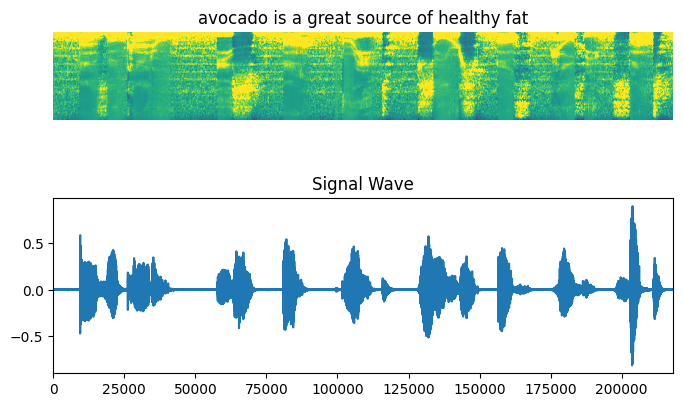

In [38]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(df_train["name"])[0] )
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=22000)) #rate=16000))
plt.show()

## Modelo CTC
Definimos la función de pérdida

In [4]:
def CTCLoss(y_true, y_pred):
    # Calcular el valor de pérdida durante el entrenamiento
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Crear vectores de longitud de entrada y etiqueta para cada elemento en el lote
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Calcular la pérdida CTC
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

### Definimos el modelo

In [40]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    # Entrada del modelo
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expandir la dimensión para usar 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # Capa de convolución 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    
    # Capa de convolución 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    
    # Redimensionar el volumen resultante para alimentar las capas RNN
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]), name="reshape_to_rnn")(x)
    
    # Capas RNN
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5, name=f"dropout_{i}")(x)
    
    # Capa densa
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_activation")(x)  # Renombrada para asegurar unicidad
    x = layers.Dropout(rate=0.5, name="dropout_final")(x)
    
    # Capa de clasificación
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    
    # Modelo
    model = models.Model(input_spectrogram, output, name="DeepSpeech_2")
    
    # Optimizador
    opt = optimizers.Adam(learning_rate=0.0001)
    
    # Compilar el modelo y devolverlo
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Corregir fft_length basado en el mensaje de error
correct_fft_length = 2 * (193 - 1)

# Reconstruir el modelo con la dimensión de entrada corregida
model = build_model(
    input_dim=193,
    output_dim=num_to_char.vocabulary_size(),
    rnn_units=512
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

### Callbacks para el entrenamiento

In [42]:
# Una función de utilidad para decodificar la salida de la red
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Utilizar búsqueda voraz. Para tareas complejas, se puede usar búsqueda con haz
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterar sobre los resultados y obtener el texto
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# Una clase de callback para mostrar algunas transcripciones durante el entrenamiento
class CallbackEval(keras.callbacks.Callback):

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)



### Metricas para medir el desempeño del modelo

In [43]:
class MetricsCheckpoint(Callback):
    """Callback que guarda métricas después de cada época"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath  # Ruta donde se guardarán las métricas
        self.history = {}  # Diccionario para almacenar las métricas

    def on_epoch_end(self, epoch, logs=None):
        """
        Método llamado al final de cada época.
        Registra las métricas en el diccionario de historial y las guarda en disco.
        """
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)  # Agrega la métrica al historial
        np.save(self.savepath, self.history)  # Guarda el historial en disco

def plot_learning_curve(history):
    """
    Función para trazar la curva de aprendizaje.
    """
    plt.figure(figsize=(8,8))
    
    # Subgráfico para la pérdida del modelo
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])  # Pérdida en el conjunto de entrenamiento
    plt.title('Pérdida del modelo')
    plt.ylabel('pérdida')
    plt.xlabel('época')
    plt.legend(['entrenamiento', 'prueba'], loc='upper left')
    plt.savefig('curva_de_perdida.png')  # Guarda la curva como imagen


### Se configura el callback que guarda el modelo cuando mejora su desempeño

In [44]:

t = time.time()  
export = './speech_to_text.h5'  
checkpoint_filepath = export 

# Se configura el callback para guardar el modelo en cada época si la pérdida es mínima
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # Ruta donde se guarda el modelo
    save_weights_only=False,  # Se guarda el modelo completo, no solo los pesos
    monitor='loss',  # Se monitoriza la pérdida
    mode='min',  # Se busca minimizar la pérdida
    save_best_only=True,  # Se guarda solo el mejor modelo en términos de pérdida
    verbose=1  # Se muestra información detallada durante el proceso
)

### Entrenamiento del modelo

In [45]:
#model=keras.models.load_model("./speech_to_text.h5", custom_objects={"CTCLoss": CTCLoss })
opt = keras.optimizers.Adam(learning_rate=0.0001)#1e-4)
model.compile(optimizer=opt, loss=CTCLoss)

Epoch 1/10
1/1 [==============================] - 0s 154ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2319
----------------------------------------------------------------------------------------------------
Target    : a good sense of humor lightens the mood
Prediction: a god sense of humor lightens the mod
----------------------------------------------------------------------------------------------------
Target    : a good sense of humor lightens the mood
Prediction: a god sense of humor lightens the mod
----------------------------------------------------------------------------------------------------

Epoch 1: loss improved from 15.72859 to 11.43185, saving model to .\speech_to_text.h5
45/45 [==============================] - 38s 838ms/step - loss: 11.4318 - val_loss: 10.5304
Epoch 2/10
1/1 [==============================] - 0s 157ms/step
-------------------------------------------------------------

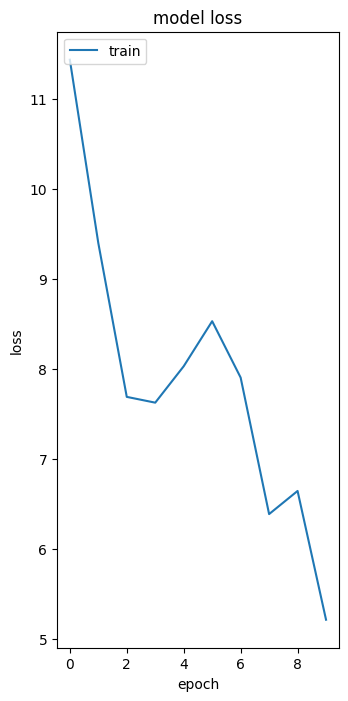

In [47]:
# Define the number of epochs.
epochs = 10
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, MetricsCheckpoint('logs'), model_checkpoint_callback],
    verbose=1
)

plot_learning_curve(history)
plt.show()


## Predicciones y evaluación

In [48]:
predictions = []
targets = []

for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

for target, prediction in zip(targets, predictions):
    print(f"Target    : {target}")
    print(f"Prediction: {prediction}")
    print("-" * 100)

1/1 [==============================] - 0s 154ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2319
----------------------------------------------------------------------------------------------------
Target    : i enjoy eating avocado toast every morning
Prediction: i enjoy eting avocado toas every morning
----------------------------------------------------------------------------------------------------
Target    : titanic is a classic film loved by many
Prediction: titanic isaclasic film lovedby many
----------------------------------------------------------------------------------------------------
Target    : a good sense of humor lightens the mood
Prediction: a god sense of humor lihens the mood
----------------------------------------------------------------------------------------------------
Target    : understanding emotion is key to empathy
Prediction: understanding emotion is key to empathy
-----

### Predicciones invididuales

In [2]:
model=keras.models.load_model("./speech_to_text.h5", custom_objects={"CTCLoss": CTCLoss })

# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Función para preprocesar una muestra individual
def preprocess_single_sample(wav_file):
    file = tf.io.read_file(wav_file)
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=160, fft_length=384)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    return spectrogram

# Función para decodificar la predicción individual usando la lógica de batch
def decode_single_prediction(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    result = tf.strings.reduce_join(num_to_char(results[0])).numpy().decode("utf-8")
    return result

# Función para predecir una muestra individual
def predict_single_sample(model, wav_file):
    spectrogram = preprocess_single_sample(wav_file)
    prediction = model.predict(spectrogram)
    decoded_prediction = decode_single_prediction(prediction)
    return decoded_prediction

# Ejemplo de uso
wav_file = 'Andrik/frase58.wav'
predicted_label = predict_single_sample(model, wav_file)
print(f"Predicted label: {predicted_label}")

1/1 [==============================] - 16s 16s/step
Predicted label: he works as a manager at the local bank


## Conclusión

Una vez realizado el modelo de transcripción de audio a texto ha mostrado resultados prometedores, obteniendo un desempeño aceptable en cuanto a la transcripcion de los audios con un error de 5% y una pérdida de validación de 11.9722% esto considerando al limitado dataset que se utilizo para el entrenamiento, no obstante el modelo reconoce las palabras clave de interes que eran la finalidad de este modelo por lo cual se puede concluir que se tuvo un resultado exitoso. No obstante todavía enfrenta desafíos al generalizar estos aprendizajes a los datos de validación. La discrepancia entre la pérdida de entrenamiento y la de validación puede indicar una cierta tendencia al sobreajuste, donde el modelo se ajusta bien a los datos específicos de entrenamiento pero no se desempeña tan bien en datos nuevos o no vistos. Esto podriamos mejorarlo si aumentamos el tamaño de nuestro dataset.